## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `creditcard.csv` que contém 31 colunas. Esse problema é o de detectar fraude em transações em cartões de crédito. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.<br><br>

<font color="blue">
Você deverá criar um notebook (ipynb) com a solução. O Notebook deverá conter as saídas para visualização dos resultados. Fazer upload no Moodle de 2 arquivos:</font>

<font color="blue">1. Notebook com o código fonte (ipynb)</font><br>
<font color="blue">2. Versão em PDF com todos os resultados</font>

Conforme código abaixo, use como características de entrada as colunas de posição 1 até 28 (marcadas no arquivo como V1 - V28), e como classe a última coluna (Class). Não utilize a coluna Amount.

As tarefas a realizar são as seguintes:

1. **Separe** os dados em:
    * conjunto S = 2,5% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2,5%, ou 7120 exemplos), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
1. **Modelo A**: denoising overcomplete autoencoder para pré-treinamento baseado em auto-supervisão
    * Arquitetura com as seguintes camadas:
        * entrada com 28 valores
        * normalização em batch
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * dropout 0.2
        * normalização em batch
        * densa 28 neurônios, relu (camada de código/bottleneck)
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * densa 28 neurônios, tanh
    * Inserção de ruído aleatório uniforme ponderado a 0.2 (insira ruído nos dados de treinamento fornecidos por entrada, mas mantenha a comparação com a saída sem ruído, como num denoising autoencoder)
    * Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br><br>
1. **Análise de projeção das características**: visualize um scatterplot com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes:
    * scatterplot com projeção PCA do conjunto de S original
    * scatterplot com projeção PCA do conjunto S após processado pelo "encoder", ou seja resultado da saída da camada de código<br><br>
    
1. **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A, e inserindo uma nova camada densa de classificação com ativação sigmóide.<br>
    * Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
    * Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
    * Treinar com perda MSE por 8 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. **Avalie a rede neural de classificação**: 
    * Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas
    * Exiba precisão e revocação calculada no treinamento S e teste T
    * Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)<br><br>

1. **Bônus:** (+1 ponto extra) compare a solução com duas outras possibilidades que não envolvam uso do conjunto **U** não rotulado
    * Rede neural profunda com a mesma arquitetura e estratégias usadas no modelo B, mas sem usar os pesos pré-treinados, inicializando e treinando com os dados em S por 15 épocas. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados originais S. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

seed(1)
set_seed(2)

In [2]:
import pandas as pd
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Parte 1: separar dados

In [3]:
X = df.drop(['Time', 'Amount', 'Class'], axis = 1).copy()
y = df[['Class']].copy()
qtd_registros = len(df)

print('X: ', X.shape)
print('Y: ', y.shape)

X:  (284807, 28)
Y:  (284807, 1)


In [4]:
S = [X.iloc[:7120].copy(), y.iloc[:7120].copy()]

print('S - X: ', S[0].shape)
print('S - Y: ', S[1].shape)

S - X:  (7120, 28)
S - Y:  (7120, 1)


In [5]:
U = [X.iloc[:int(qtd_registros/2)].copy(), y.iloc[:int(qtd_registros/2)].copy()]

print('U - X: ', U[0].shape)
print('U - Y: ', U[1].shape)

U - X:  (142403, 28)
U - Y:  (142403, 1)


In [6]:
T = [X.iloc[int(qtd_registros/2):].copy(), y.iloc[int(qtd_registros/2):].copy()]

print('T - X: ', T[0].shape)
print('T - Y: ', T[1].shape)

T - X:  (142404, 28)
T - Y:  (142404, 1)


### Parte 2: Modelo A

In [7]:
seed(1)
set_seed(2)

In [8]:
input_data = keras.layers.Input(shape=28)
x = keras.layers.BatchNormalization()(input_data)

x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(28, activation='relu', name='code')(x)

x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.Dense(32, activation='relu')(x)

output = keras.layers.Dense(28, activation = 'tanh')(x)

model_a = keras.models.Model(input_data, output)

In [9]:
model_a.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [10]:
batch_size = 16
epochs = 20
noise_factor = 0.2

In [11]:
x_train = np.array(U[0])

x_train_noised = x_train + noise_factor * np.random.normal(0, 1, x_train.shape)

In [12]:
def scheduler_model_a(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4) 

In [13]:
callback_model_a = keras.callbacks.LearningRateScheduler(scheduler_model_a)

In [14]:
model_a.compile(
            loss = 'mse',
            optimizer = keras.optimizers.Adam(lr = 0.003)
            )

In [15]:
hist_model_a = model_a.fit(
        x = x_train_noised,
        y = x_train,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [callback_model_a],
        verbose = 1
        )

Epoch 1/20
8901/8901 [==============================] - 40s 4ms/step - loss: 0.6200
Epoch 2/20
8901/8901 [==============================] - 41s 5ms/step - loss: 0.5616
Epoch 3/20
8901/8901 [==============================] - 41s 5ms/step - loss: 0.5504
Epoch 4/20
8901/8901 [==============================] - 40s 5ms/step - loss: 0.5438
Epoch 5/20
8901/8901 [==============================] - 40s 4ms/step - loss: 0.5379
Epoch 6/20
8901/8901 [==============================] - 41s 5ms/step - loss: 0.5316
Epoch 7/20
8901/8901 [==============================] - 40s 5ms/step - loss: 0.5265
Epoch 8/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5236
Epoch 9/20
8901/8901 [==============================] - 37s 4ms/step - loss: 0.5208
Epoch 10/20
8901/8901 [==============================] - 42s 5ms/step - loss: 0.5192
Epoch 11/20
8901/8901 [==============================] - 39s 4ms/step - loss: 0.5174
Epoch 12/20
8901/8901 [==============================] - 40s 4ms/step - lo

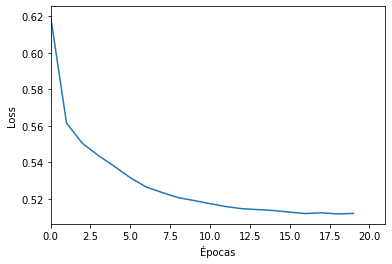

In [16]:
plt.plot(hist_model_a.history['loss'])
plt.xlim(0, 21)
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.show();

### Parte 3: Análise da projeção das características

In [17]:
from sklearn.decomposition import PCA

In [18]:
x_train = np.array(S[0])
y_train = np.array(S[1])

In [46]:
pca = PCA(n_components = 2)
pca.fit(x_train)
pca_train = pca.transform(x_train)

ValueError: array must not contain infs or NaNs

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(
                    pca_train[:,0]
                ,   pca_train[:,1]
                ,   c = y_train[:]
                ,   cmap='viridis'
                )
legend = ax.legend(
                    *scatter.legend_elements()
                ,   loc='best'
                ,   title='Classes'
                )
ax.add_artist(legend);

In [ ]:
model_code = keras.models.Model(
                            inputs = model_a.input
                        ,   outputs = model_a.get_layer('code').output
                        )

In [ ]:
code_train = np.asarray(model_code.predict(x_train))

In [ ]:
pca = PCA(n_components = 2)
pca.fit(code_train)
pca_train = pca.transform(code_train)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(
                    code_train[:,0]
                ,   code_train[:,1]
                ,   c = y_train[:]
                ,   cmap='viridis'
                )
legend = ax.legend(
                    *scatter.legend_elements()
                ,   loc='best'
                ,   title='Classes'
                )
ax.add_artist(legend);

### Parte 4: Modelo B

In [ ]:
encoder = keras.models.Model(
                        inputs = model_a.input
                    ,   outputs = model_a.get_layer(name = 'code').output
                    )

In [ ]:
new_model = keras.models.Sequential()
new_model.add(
                keras.layers.Dense(
                    1,
                    activation = 'sigmoid',
                    name = 'pred',
                    input_shape = encoder.output_shape[1:]
                    )
                )

model_b = keras.models.Model(
    inputs = encoder.input,
    outputs = new_model(encoder.output)
    )

In [ ]:
model_b.summary()

In [ ]:
batch_size = 16
epochs = 8
class_weight = {0: 0.1, 1: 0.9}

In [ ]:
x_train = np.array(U[0])
y_train = np.array(U[1])

In [ ]:
def scheduler_model_b(epoch, lr):
    return np.round(lr * tf.math.exp(-0.3),4)    

In [ ]:
callback_model_b = keras.callbacks.LearningRateScheduler(scheduler_model_b)

In [ ]:
model_b.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(lr = 0.001),
    metrics = [
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
            ]
    )

In [ ]:
hist_model_b = model_b.fit(
                x = x_train,
                y = y_train,
                batch_size = batch_size,
                epochs = epochs,
                callbacks = [ callback_model_b ],
                class_weight = class_weight,
                verbose = 1
                ) 

### Parte 5: Avaliação da rede neural de classificação

In [ ]:
fig, axes = plt.subplots(figsize = (16,8))

plt.plot(hist_model_b.history['precision'], label = 'precision')
plt.plot(hist_model_b.history['recall'], label = 'recall')

plt.title('Modelo B: Precision e Recall')
plt.xlabel('Épocas')
plt.xlim(0, 8)
plt.legend(['Precision', 'Recall'], loc = 'best')
fig.tight_layout()
plt.show();

In [ ]:
score_S = modelB.evaluate(S[0], S[1], verbose=0)
print("S - PRECISION: " , round(score[1], 4))
print("S - RECALL:" , round(score[2], 4))

In [ ]:
score_T = modelB.evaluate(T[0], T[1], verbose=0)
print("T - PRECISION: " , round(score[1], 4))
print("T - RECALL: " , round(score[2], 4))

In [ ]:
model_code_2 = keras.models.Model(
    inputs = mpdel_b.input,
    outputs = mpdel_b.get_layer('code').output
    )

In [ ]:
code_train_2 = np.asarray(model_code_2.predict(S[0]))

In [ ]:
plt.scatter(
    code_train_2[:,0], code_train_2[:,1]
    , c = S[1][:].values, cmap='viridis'
    )
plt.colorbar();

### Bônus: Tentando outros métodos para treinar com os poucos dados rotulados

#### Tentativa 1: DNN com a mesma arquitetura usada, mas sem pré-treinamento

In [ ]:
encoder_bonus = keras.models.Model(
                inputs = model_a.input,
                outputs = model_a.get_layer(name = 'code').output
            )

In [ ]:
modelo_novo = keras.models.Sequential()
modelo_novo.add(
    keras.layers.Dense(
        1,
        activation = 'sigmoid',
        name = 'pred',
        input_shape = encoder_bonus.output_shape[1:]
        )
    )

model_dnn = keras.models.Model(
    inputs = encoder_bonus.input,
    outputs = modelo_novo(encoder_bonus.output)
    )

In [ ]:
model_dnn.summary()

In [ ]:
batch_size = 16
epochs = 15

In [ ]:
x_train = np.array(S[0])
y_train = np.array(S[1])

In [ ]:
def scheduler_dnn(epoch, lr):
    return np.round(lr * tf.math.exp(-0.3),4)    

In [47]:
callback_dnn = keras.callbacks.LearningRateScheduler(scheduler_dnn)

In [48]:
model_dnn.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(lr = 0.001),
    metrics = [
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
        ]
    )

In [49]:
hist_dnn = model_dnn.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ callback_dnn ],
    verbose = 1
    )

Epoch 1/15
445/445 [==============================] - 2s 5ms/step - loss: 0.0520 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2/15
445/445 [==============================] - 2s 5ms/step - loss: 0.0042 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/15
445/445 [==============================] - 2s 5ms/step - loss: 0.0037 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4/15
445/445 [==============================] - 2s 4ms/step - loss: 0.0036 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/15
445/445 [==============================] - 2s 4ms/step - loss: 0.0035 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6/15
445/445 [==============================] - 2s 4ms/step - loss: 0.0035 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 7/15
445/445 [==============================] - 2s 5ms/step - loss: 0.0035 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 8/15
445/445 [==============================] - 2s 5ms/step - loss: 0.0034 - precisi

In [50]:
score_S = hist_dnn.evaluate(S[0], S[1], verbose=0)
print(f'Conjunto S:\nPrecisão: {np.round(score_S[1], 4)}\nRevocação: {np.round(score_S[2], 4)}')

Conjunto S:
Precisão: 1.0
Revocação: 0.16


In [51]:
score_T = modelDNN.evaluate(T[0], T[1], verbose=0)
print(f'Conjunto T:\nPrecisão: {np.round(score_T[1], 4)}\nRevocação: {np.round(score_T[2], 4)}')

Conjunto T:
Precisão: 1.0
Revocação: 0.0045


#### Tentativa 2: SVM nos dados originais

In [52]:
x_train = np.array(S[0])
y_train = np.array(S[1])

In [53]:
x_test = np.array(T[0])
y_test = np.array(T[1])

In [54]:
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = svm.SVC(C = 10, random_state = 42)

clf.fit(x_train, y_train)

SVC(C=10, random_state=42)

In [55]:
y_pred = clf.predict(x_train)

print(f'Conjunto S:\nPrecisão: {np.round(precision_score(y_train, y_pred), 4)}\nRevocação: {np.round(recall_score(y_train, y_pred), 4)}')

Conjunto S:
Precisão: 1.0
Revocação: 1.0


In [56]:
y_pred = clf.predict(x_test)

print(f'Conjunto T:\nPrecisão: {np.round(precision_score(y_test, y_pred), 4)}\nRevocação: {np.round(recall_score(y_test, y_pred), 4)}')

Conjunto T:
Precisão: 0.6538
Revocação: 0.1525


In [57]:
modelSVM = keras.models.Model(
    inputs = modelB.input,
    outputs = modelB.get_layer('code').output
    )

In [58]:
codeSVM_train = np.array(modelSVM.predict(np.array(S[0])))
y_train = np.array(S[1])

In [59]:
codeSVM_test = np.array(modelSVM.predict(np.array(T[0])))
y_test = np.array(T[1])

In [60]:
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = svm.SVC(C = 10, random_state = 1)

clf.fit(codeSVM_train, y_train)

SVC(C=10, random_state=1)

In [61]:
y_pred = clf.predict(codeSVM_train)

print(f'Conjunto S:\nPrecisão: {np.round(precision_score(y_train, y_pred), 4)}\nRevocação: {np.round(recall_score(y_train, y_pred), 4)}')

Conjunto S:
Precisão: 1.0
Revocação: 0.92


In [62]:
y_pred = clf.predict(codeSVM_test)

print(f'Conjunto T:\nPrecisão: {np.round(precision_score(y_test, y_pred), 4)}\nRevocação: {np.round(recall_score(y_test, y_pred), 4)}')

Conjunto T:
Precisão: 0.7917
Revocação: 0.2556
